# Can we correctly produce a DPP?

And then sample from it. We want to get the kernel from data first.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
import sklearn.metrics

# This gives P(A \subset Y) = det(K_A)
def corr_k(K,points):
    Kp = K[points][:,points]

    if len(Kp.shape) > 1: 
        return np.linalg.det(Kp)
    else:
        return K

def select_eigenvalues_from_L(eig_vals):
    N = len(eig_vals)
    indices = np.arange(N)
    bern_probs = eig_vals / (eig_vals + 1)
    
    selected_indices = np.random.rand(N) <= bern_probs
            
    return indices[selected_indices]
    
def select_samples_from_L(eig_vecs):
    samples = [] 
    N, n_samples = V.shape
    indices = np.arange(N)    
    avail = np.ones(N, dtype=bool) 
    
    c = np.zeros((N, n_samples)) # Used for Gram-Schmidt
    normVT2 = (V**2).sum(axis = 1)
    
    for i in range(n_samples):
        probs = normVT2[avail] / (n_samples - i)  
        probs[probs < 0] = 0 # Compensate for small negatives due to round off
        j = np.random.choice(indices[avail], p=probs)

        samples.append(j)
        avail[j] = False
        # Cancel the contribution of V^T_j to the remaining feature vectors
        c[:, i] = (V @ V[j, :] - c[:, 0:i] @ c[j, 0:i]) / np.sqrt(normVT2[j])
        normVT2[:] -= c[:, i]**2

    return np.array(samples)


# K-DPP sampling requires computation of elementary symmetric polynomials
def elementary_symmetric_polynomial(k, eig_vals):
    N = len(eig_vals)
    
    e = np.zeros([k + 1, N + 1])
    e[0, :] = 1.0

    for l in range(1, k + 1):
        for n in range(1, N + 1):
            e[l, n] = e[l, n - 1] + eig_vals[n - 1] * e[l - 1, n - 1]
    return e

def select_k_eigenvalues_from_L(k,eig_vals):

    e = elementary_symmetric_polynomial(k,eig_vals)
    N = len(eig_vals)

    sample_idx = []
    for n in range(N,0,-1):
        thresh = eig_vals[n-1] * e[k-1,n-1] / e[k,n]
        if np.random.rand() <= thresh:
            sample_idx.append(n-1)
            k -= 1
            if k == 0:
                break

    return sample_idx    


In [2]:
# Generate the points that we sample from
line = np.linspace(0,1,10)
x,y = np.meshgrid(line,line)
d = np.stack([x.flatten(), y.flatten()], axis = 1)

# Mimic the conditions in our code
# d = np.random.randn(1024,128) # d = [batch_size, number_nodes]
# d = d.transpose()

# Kernel is exp( -||d_i - d_j||^2 / N). This is an L-ensemble
dist = np.linalg.norm(d[:,None,:] - d[None,:,:],axis = -1)
N = d.shape[-1]



##### GAUSSIAN KERNEL
# L = np.exp(- 20 * dist**2 / N) 


##### SINE KERNEL
div_val = 30
L = np.sin(np.pi * dist / div_val) / (np.pi * dist / div_val) 
L[np.isnan(L)] = 1 # sin(x)/x = 1




############################### For sampling
##### Get EigenValues
eig_vals, eig_vecs = np.linalg.eigh(L)


##### Calculate marginal kernel (K)
K = eig_vecs @ np.diag(eig_vals / (eig_vals + 1)) @ eig_vecs.T

# plt.imshow(L, interpolation = 'none')
# plt.show()

# plt.imshow(K)
# plt.show()

print('N')
print(N)

print('Expected Cardinality of Samples')
print(np.sum( eig_vals / (eig_vals + 1)))

print('Variance of Cardinality Samples')
print(np.sum( eig_vals / (eig_vals + 1)**2 ))

print('Eigenvalues')
print(eig_vals[0:10])

N
2
Expected Cardinality of Samples
1.061850667286496
Variance of Cardinality Samples
0.07899530723573703
Eigenvalues
[-1.53038313e-14 -1.38947971e-14 -1.28399144e-14 -1.27004463e-14
 -1.04610681e-14 -9.90070290e-15 -9.07516419e-15 -7.08097054e-15
 -6.51952671e-15 -5.27561131e-15]


/usr/local/pkgs/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


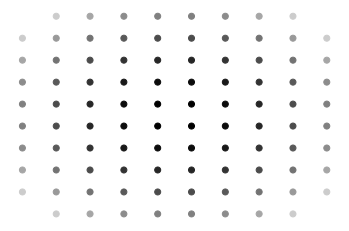

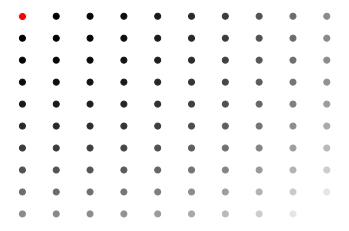

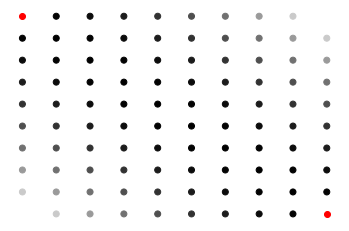

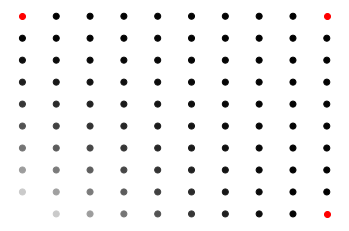

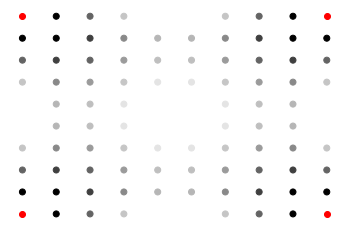

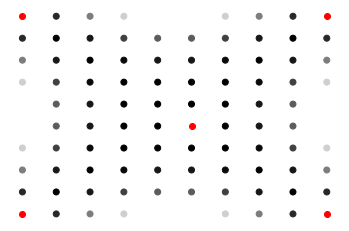

In [3]:
# What is the probability of each point with no points selected
colors = np.diag(K)
plt.scatter(d[:,0],d[:,1],c = colors, cmap = 'gray')
plt.axis('off')
plt.show()

point_idx = []
vals_to_add = np.array([90,9,99,0, 45])
# vals_to_add = vals_to_add * 25 
for val in vals_to_add:
    point_idx.append(val)
    # Ok, we have a point. Now the probabilities are updated 

    # Bust out some bayes: p(a|b) = p(a and b) / p(b)
    # p(a and b) = K[point_idx,point_idx] K[i,i] - (K[i,point_idx])**2
    # p(b) = K[point_idx,point_idx]

    def corr_k(K,points):
        Kp = K[points][:,points]

        if len(Kp.shape) > 1: 
            return np.linalg.det(Kp)
        else:
            return K


    p = []
    idxs = []
    for i in range(d.shape[0]):
        points = [i]
        points.extend(point_idx)
        if i in point_idx:
            continue        
        idxs.append(i)
        prob = corr_k(K,points) / corr_k(K,point_idx)
        p.append(prob)
    
    plt.scatter(d[idxs,0],d[idxs,1],c = p, cmap = 'gray')
    plt.scatter(d[point_idx,0],d[point_idx,1] ,color = 'red')
    plt.axis('off')
    plt.show()

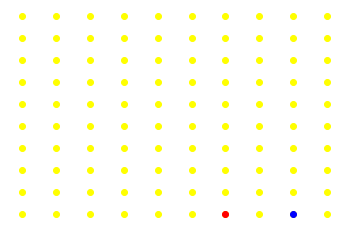

In [49]:
##### Sample from DPP in a two stage process
# Select eigenvectors
vec_idx = select_eigenvalues_from_L(eig_vals) 
V = eig_vecs[:,vec_idx]

# Select samples from eigenvalues
sample_idx = select_samples_from_L(V)

samples = d[sample_idx,:]


n = d.shape[0]

p_samples = np.random.choice(n,size = len(samples))
p_samples = d[p_samples,:]

plt.scatter(d[:,0],d[:,1], color = 'yellow')
plt.scatter(samples[:,0], samples[:,1], color = 'red')
# plt.show()

plt.scatter(p_samples[:,0], p_samples[:,1], color = 'blue')


plt.axis('off')

plt.show()


# Sampling from k-DPPs


DPPs provide a flexible way of modeling the content of sets of random points. However, it is not straightforward to have strict control over the cardinality of these sets. Thus, we turn to $k$-DPPs. $k$-DPPs are DPPs conditional on the DPP containing $k$ points. 

The conditional probabilities of the $k$-DPPs are not DPPs aside from some simple cases. However, there exist efficient methods to sample from them none the less. Here, we implement methods to sample from $k$-DPPs.






One major drawback of sampling $k$-DPPs is that it requires the spectral decomposition of of $L,K$ matrices. There are methods for sampling from $DPPs$ that rely on the Cholesky decomposition — side-stepping $n^3$ spectral decomposition. 

This paper: https://arxiv.org/pdf/2006.16947.pdf

Might have a better way of sampling from $k$-DPPs but it's a significantly more involved process and less efficient for small problems.


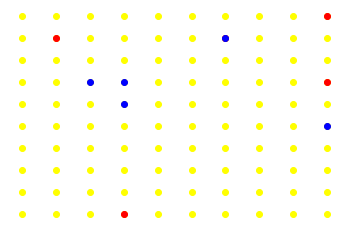

In [54]:
# Sample from a k-DPP - Notice that red points are more spread out

k = 5
vec_idx = select_k_eigenvalues_from_L(k,eig_vals) 
V = eig_vecs[:,vec_idx]

# Select samples from eigenvalues
sample_idx = select_samples_from_L(V)
samples = d[sample_idx,:]


n = d.shape[0]

p_samples = np.random.choice(n,size = len(samples))
p_samples = d[p_samples,:]

plt.scatter(d[:,0],d[:,1], color = 'yellow')
plt.scatter(samples[:,0], samples[:,1], color = 'red')
# plt.show()

plt.scatter(p_samples[:,0], p_samples[:,1], color = 'blue')

plt.axis('off')
plt.show()

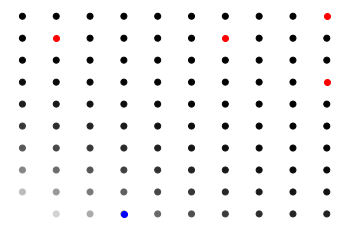

In [55]:
##### Conditional probabilities given the k-DPP sample above

point_idx = sample_idx[:-1].tolist()
next_realized_point = [sample_idx[-1].tolist()]

p = []
idxs = []
for i in range(d.shape[0]):
    points = [i]
    points.extend(point_idx)
    if i in point_idx:
        continue        
    idxs.append(i)
    prob = corr_k(K,points) / corr_k(K,point_idx)
    p.append(prob)

plt.scatter(d[idxs,0],d[idxs,1],c = p, cmap = 'gray') # Plot probabilities
plt.scatter(d[point_idx,0],d[point_idx,1] ,color = 'red') # Plot conditioning points
plt.scatter(d[next_realized_point,0],d[next_realized_point,1] ,color = 'blue') # Plot conditioning points
plt.axis('off')
plt.show()

# Comparing speed of sampling from a k-DPP vs DPP

In [13]:
%%timeit
##### Sample from DPP in a two stage process
# Select eigenvectors
vec_idx = select_eigenvalues_from_L(eig_vals) 
V = eig_vecs[:,vec_idx]

# Select samples from eigenvalues
sample_idx = select_samples_from_L(V)
samples = d[sample_idx,:]
n = d.shape[0]

57 µs ± 137 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [17]:
%%timeit
#### Sample from a k-DPP
k = 2
vec_idx = select_k_eigenvalues_from_L(k,eig_vals) 
V = eig_vecs[:,vec_idx]

# Select samples from eigenvalues
sample_idx = select_samples_from_L(V)
samples = d[sample_idx,:]
n = d.shape[0]

195 µs ± 6.27 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


(100, 100)